In [1]:
import cv2
import os
import numpy as np
from skimage.segmentation import find_boundaries
import time

from skimage.segmentation import morphological_chan_vese
from sklearn.metrics.cluster import adjusted_mutual_info_score

import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
dpi = matplotlib.rcParams['figure.dpi']

from segmentation_codes.WARem_multiband import get_hierSeg_WSarcs_arcRemove_Multiband
from segmentation_codes.evaluationMetrics import getSeg,getEvalScores
from segmentation_codes.stateofarts import Ncut,RAGmerge

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [4]:
def generateEvaluationPlot(imageName,noOfObj=1):
    img=cv2.imread(os.path.join('sample_Wiezmann_data',str(noOfObj)+'obj',imageName,'src_color',imageName+'.png')).astype(np.float)
    dispSize = 1.35*img.shape[1] / float(dpi), 1.35*img.shape[0] / float(dpi)

    row,col=1,1
    fig, (ax1) = plt.subplots(row,col,figsize=(dispSize[0]*col,dispSize[1]*row))
    ax1.set_title('Original Image')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.show()

    gtfileNames=os.listdir(os.path.join('sample_Wiezmann_data',str(noOfObj)+'obj',imageName,'human_seg'))
    row,col=1,len(gtfileNames)
    fig, ax = plt.subplots(row,col,figsize=(dispSize[0]*col,dispSize[1]*row))
    gtObj=[]
    for n in range(len(gtfileNames)):
        thisObjImg=cv2.imread(os.path.join('sample_Wiezmann_data',str(noOfObj)+'obj',imageName,'human_seg',gtfileNames[n]))
        ax[n].set_xticks([])
        ax[n].set_yticks([])
        ax[n].imshow(cv2.cvtColor(thisObjImg, cv2.COLOR_BGR2RGB))
        ax[n].set_title('Ground Truth - '+str(n+1))

        gtSeg=np.ones((thisObjImg.shape[0],thisObjImg.shape[1]),dtype=np.int)
        for i in range(thisObjImg.shape[0]):
            for j in range(thisObjImg.shape[1]):
                if thisObjImg[i,j,0]==thisObjImg[i,j,1]==thisObjImg[i,j,2]: continue
                if thisObjImg[i,j,2]==255: gtSeg[i,j]=2
                elif thisObjImg[i,j,0]==255: gtSeg[i,j]=3
        gtObj.append(gtSeg)
    plt.show()

    def colorImage(segments):
        colours=np.random.randint(255, size=(np.max(segments)+1, 3),dtype=np.uint8)
        seg = np.zeros((segments.shape[0],segments.shape[1],3),dtype=np.uint8)
        for i in range(segments.shape[0]):
            for j in range(segments.shape[1]):
                seg[i,j]=colours[segments[(i,j)]]
        return seg

    def showResultPlot(method_seg,bestMatchedGtIndex=None, ca=None, ami=None, ari=None, t=None, methodName=''):
        dispSize = 1.5*method_seg.shape[1] / float(dpi), 1.5*method_seg.shape[0] / float(dpi)
        row,col=1,2
        fig, (ax2, ax3) = plt.subplots(row,col,figsize=(dispSize[0]*col,dispSize[1]*row))
        
        ax2.set_xticks([])
        ax2.set_yticks([])
        ax2.imshow(colorImage(method_seg))
        
        ax3.set_xticks([])
        ax3.set_yticks([])
        ax3.axis('off')
        ax3.text(0,.85,methodName,size=15, weight='bold')
        ax3.text(0,.7,'Run-time : '+str(np.round(t,2))+' sec',size=12)
        ax3.text(0,.6,'best match : GT-'+str(bestMatchedGtIndex+1),size=12)
        ax3.text(0,.5,'ARI score : '+str(np.round(ari,4)),size=12)
        ax3.text(0,.4,'AMI score : '+str(np.round(ami,4)),size=12)
        ax3.text(0,.3,'CA score : '+str(np.round(ca,4)),size=12)
        plt.show()

    t=time.time()
    Hierarchies_WAR=get_hierSeg_WSarcs_arcRemove_Multiband(img,nhood=8,beta=[2])
    t=time.time()-t
    method_seg=getSeg(Hierarchies_WAR)
    bestMatchedGtIndex, ca, ami, ari = getEvalScores(gtObj,method_seg, evalPriority='AMI', binaryLabel=False,obj=noOfObj)
    showResultPlot(method_seg, t=t,methodName='Watershed Arcs Removal',bestMatchedGtIndex=bestMatchedGtIndex, ca=ca, ami=ami, ari=ari)

    t=time.time()
    method_seg=Ncut(img)
    t=time.time()-t
    bestMatchedGtIndex, ca, ami, ari = getEvalScores(gtObj,method_seg, evalPriority='AMI', binaryLabel=False,obj=noOfObj)
    showResultPlot(method_seg, t=t,methodName='Normalized Cut',bestMatchedGtIndex=bestMatchedGtIndex, ca=ca, ami=ami, ari=ari)
    
    t=time.time()
    method_seg=RAGmerge(img)
    t=time.time()-t
    bestMatchedGtIndex, ca, ami, ari = getEvalScores(gtObj,method_seg, evalPriority='AMI', binaryLabel=False,obj=noOfObj)
    showResultPlot(method_seg, t=t,methodName='RAG Merging',bestMatchedGtIndex=bestMatchedGtIndex, ca=ca, ami=ami, ari=ari)

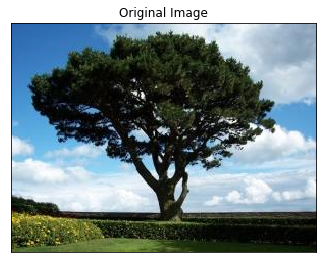

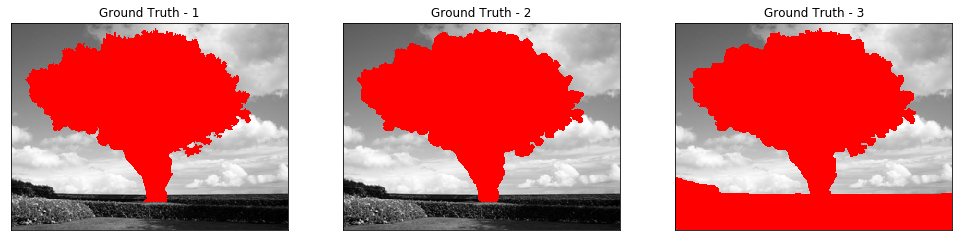

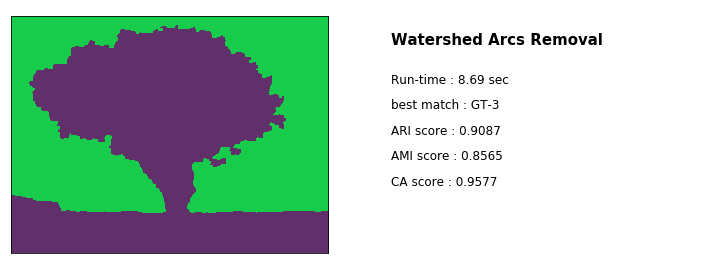

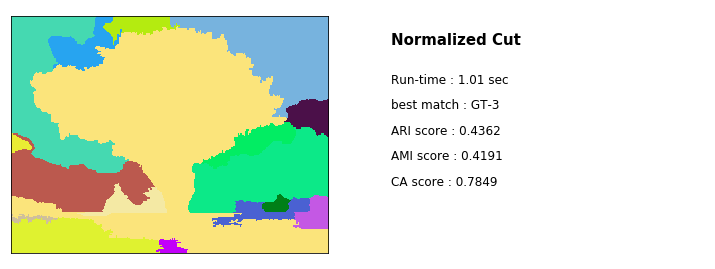

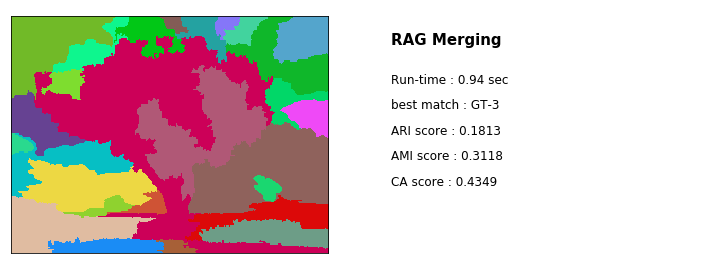

In [3]:
generateEvaluationPlot('100_0109',noOfObj=1)

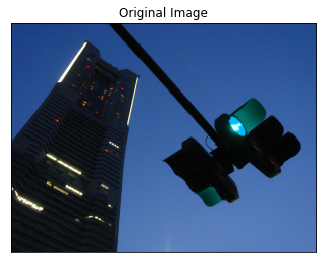

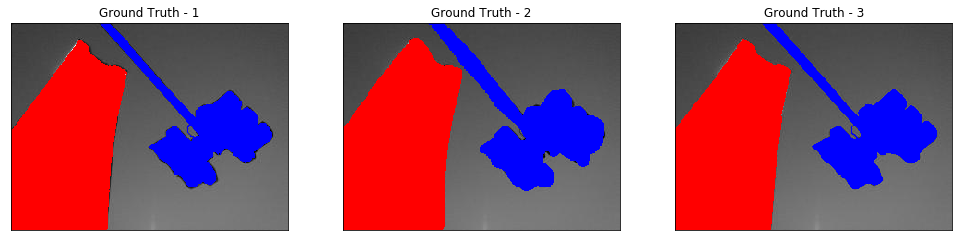

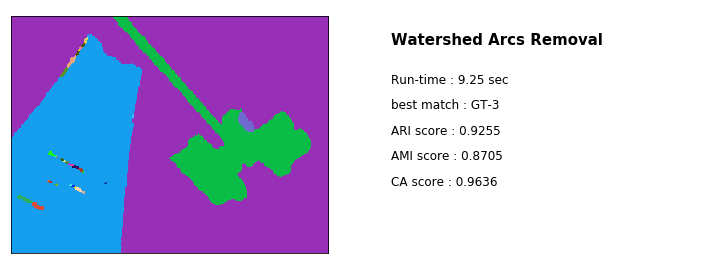

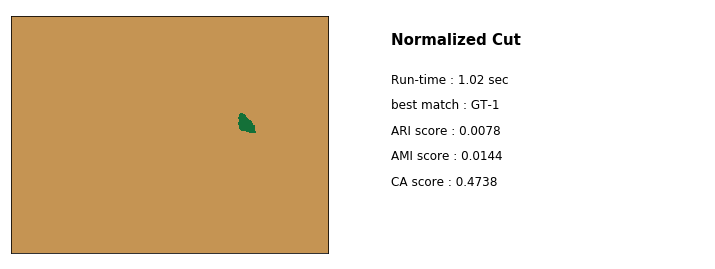

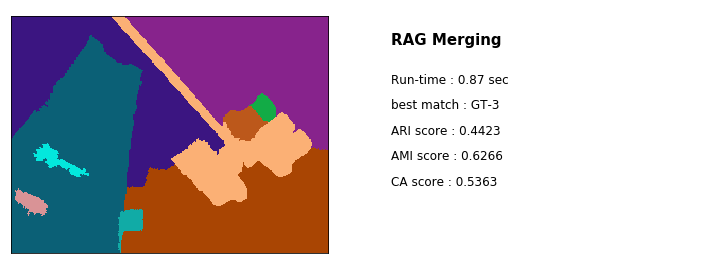

In [5]:
generateEvaluationPlot('sakurag060521_dysn34',noOfObj=2)

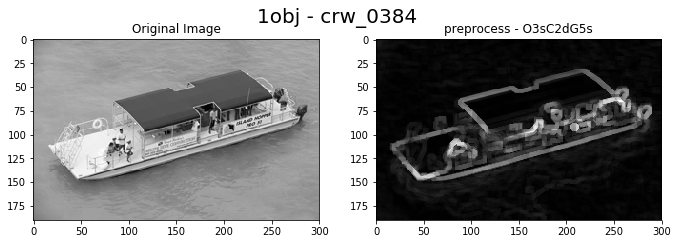

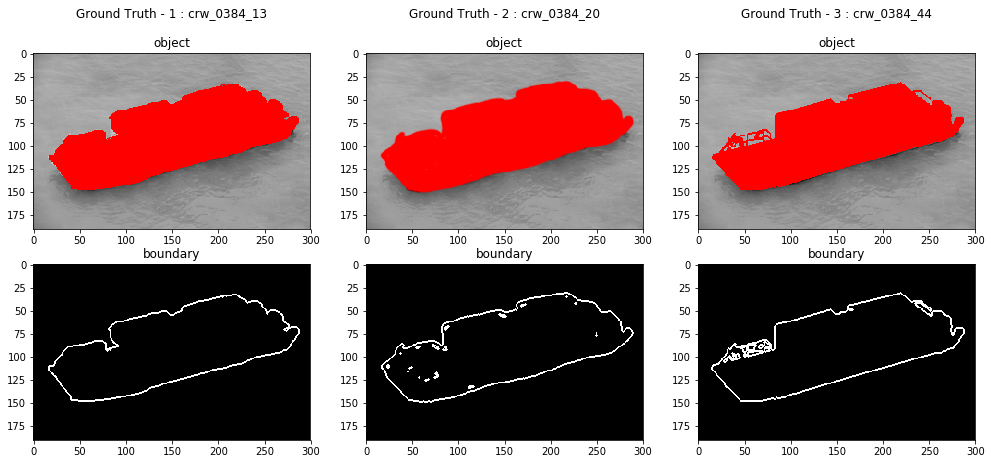

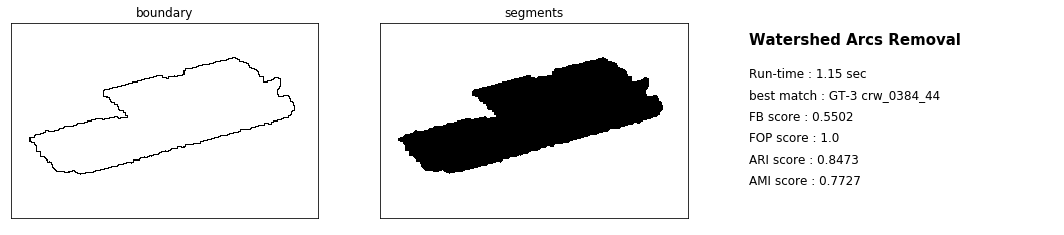

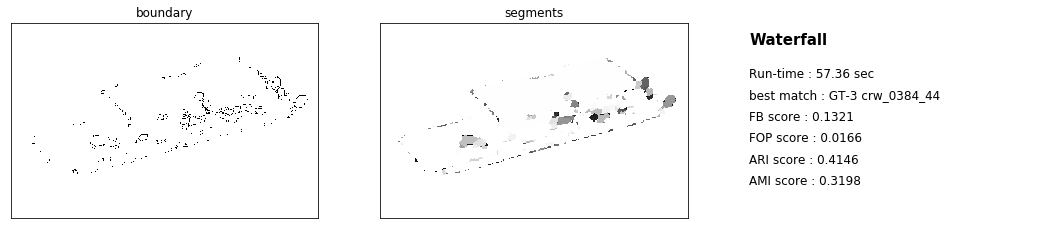

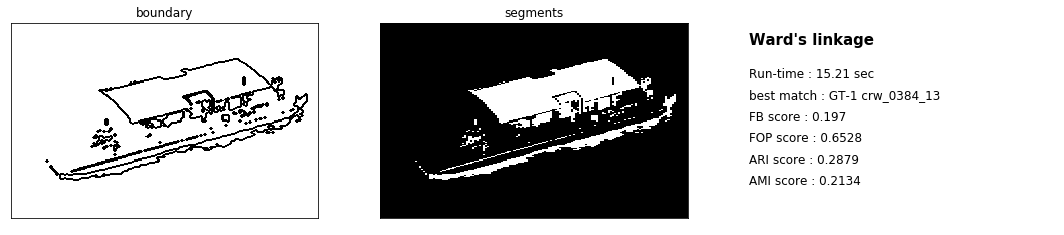

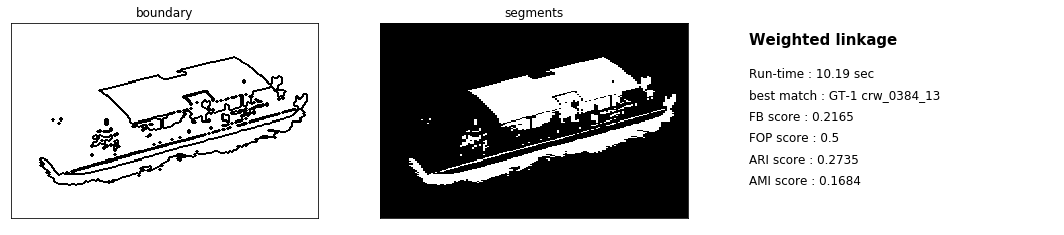

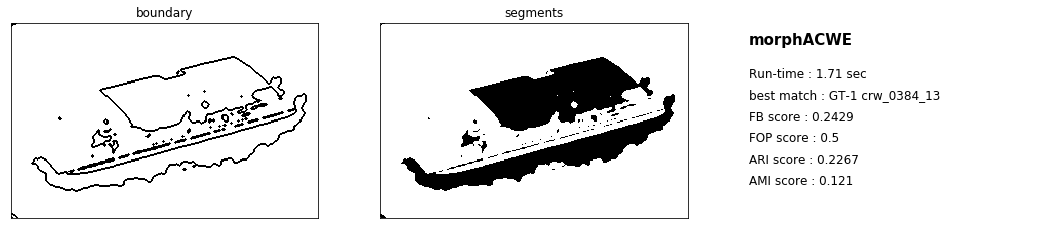

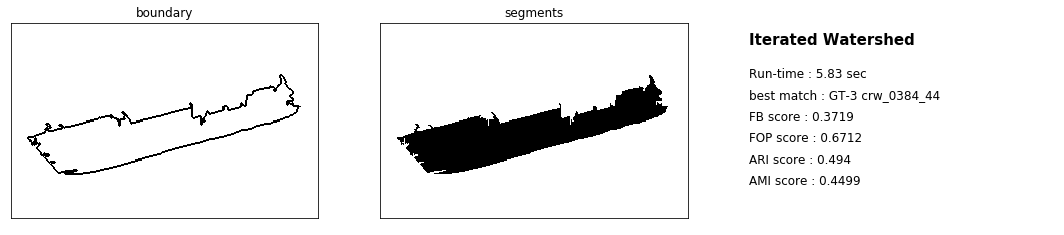

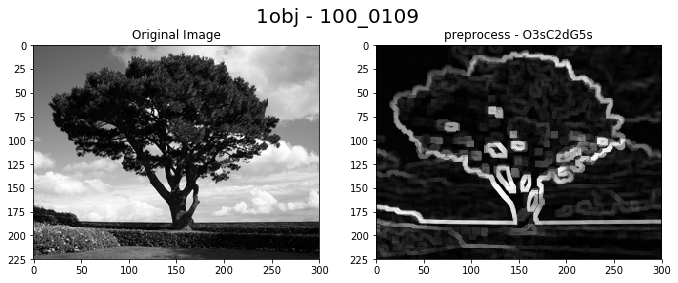

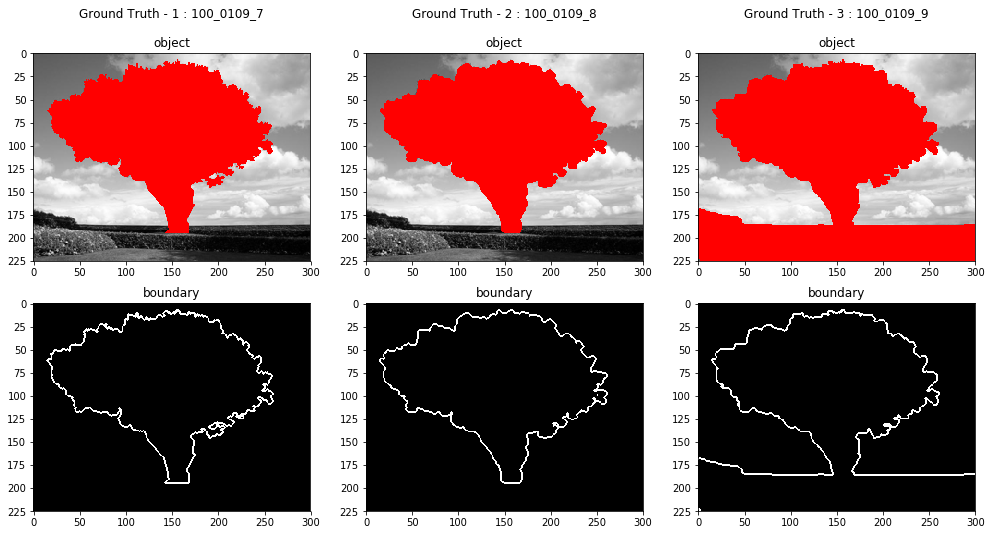

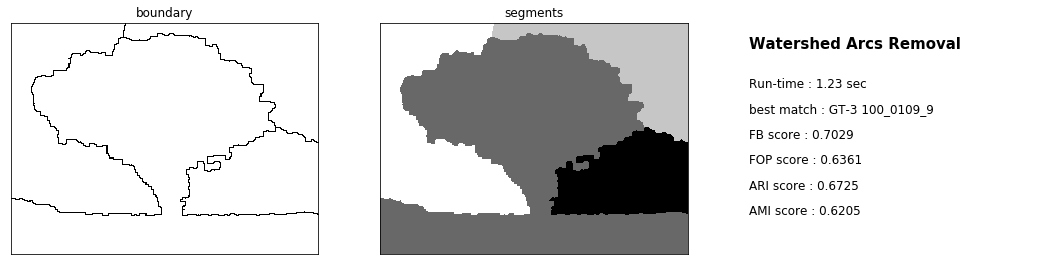

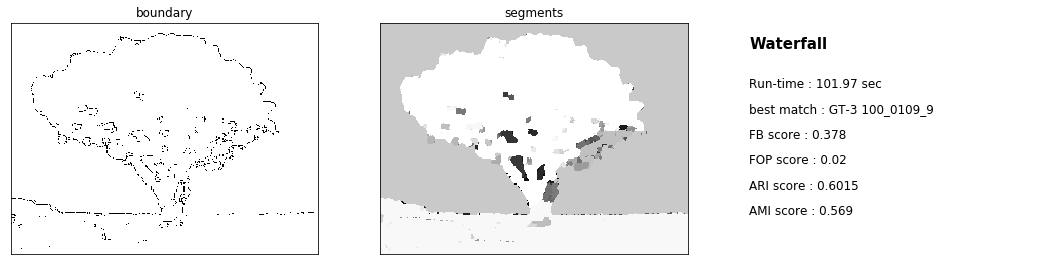

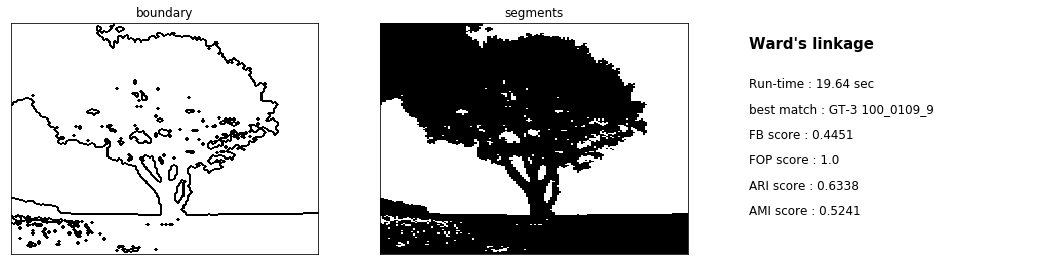

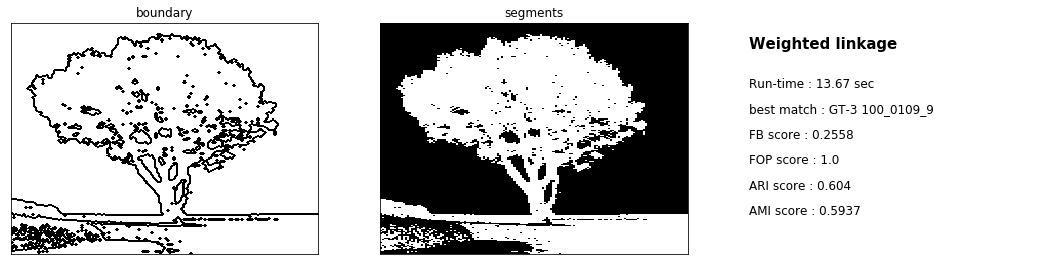

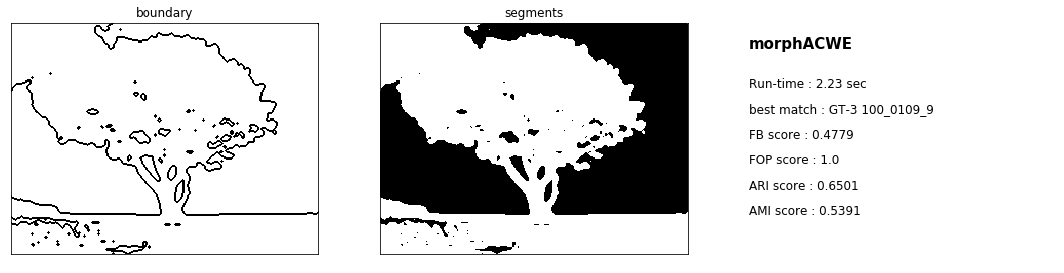

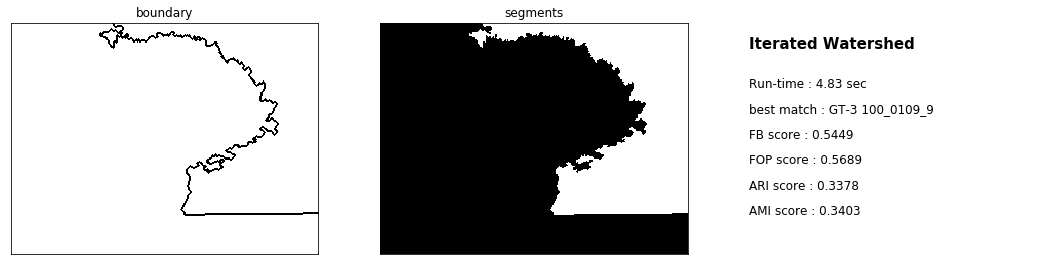

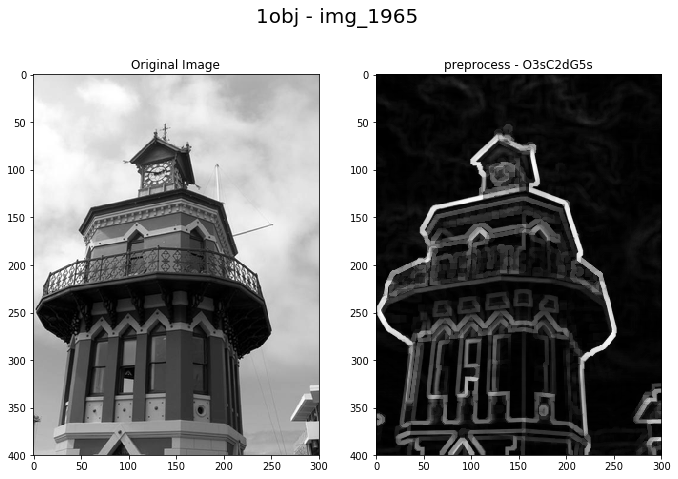

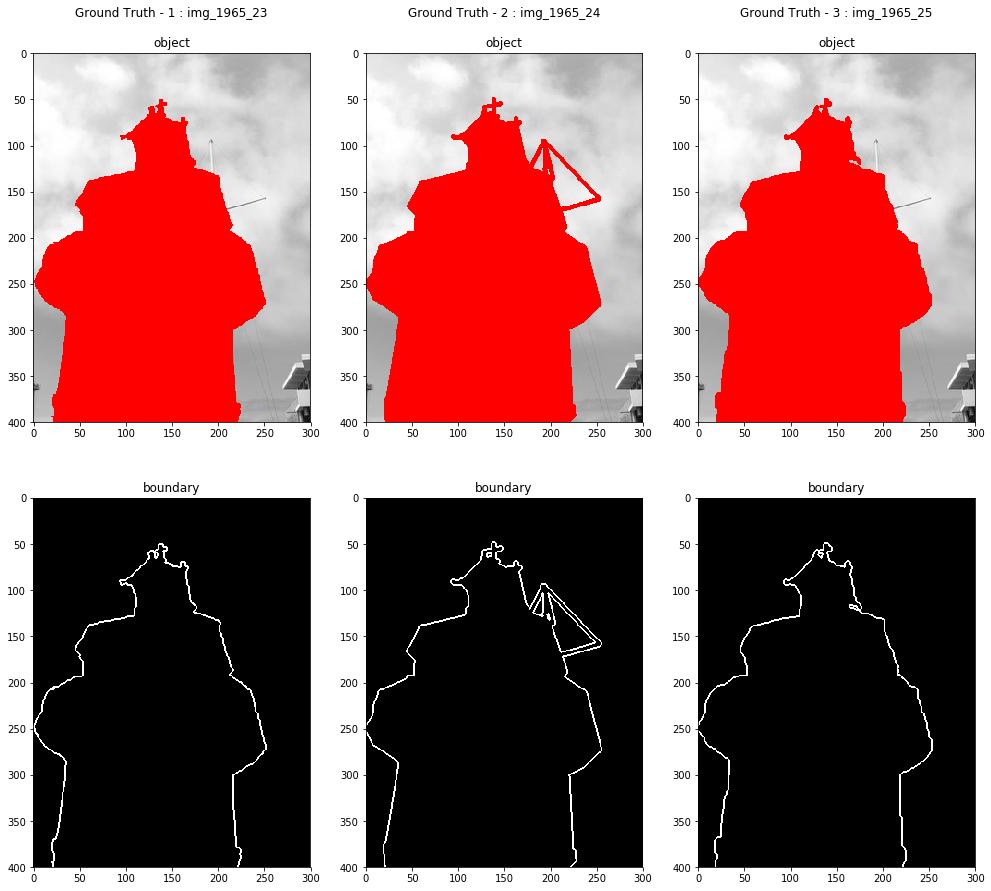

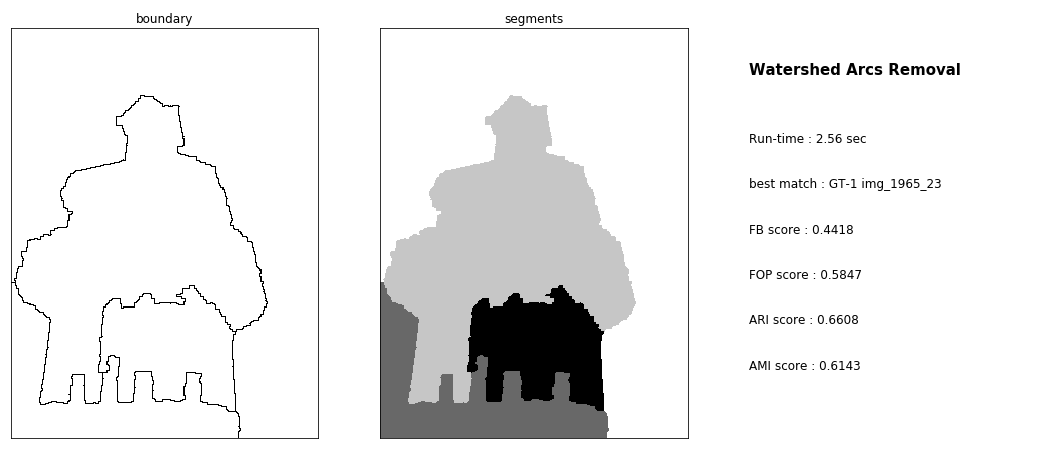

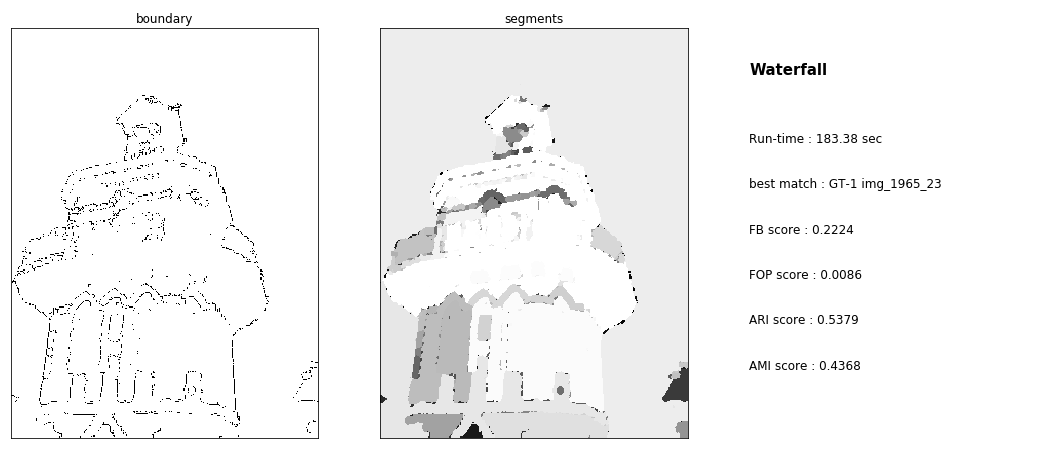

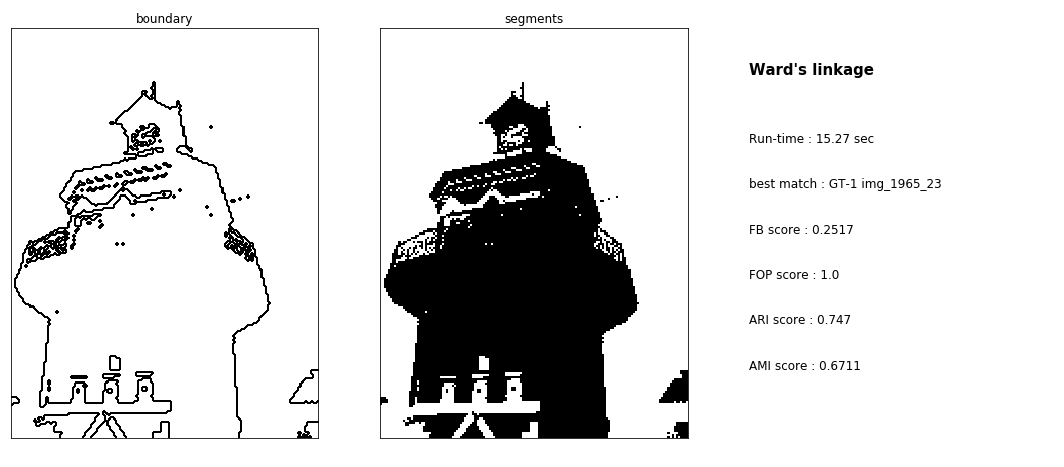

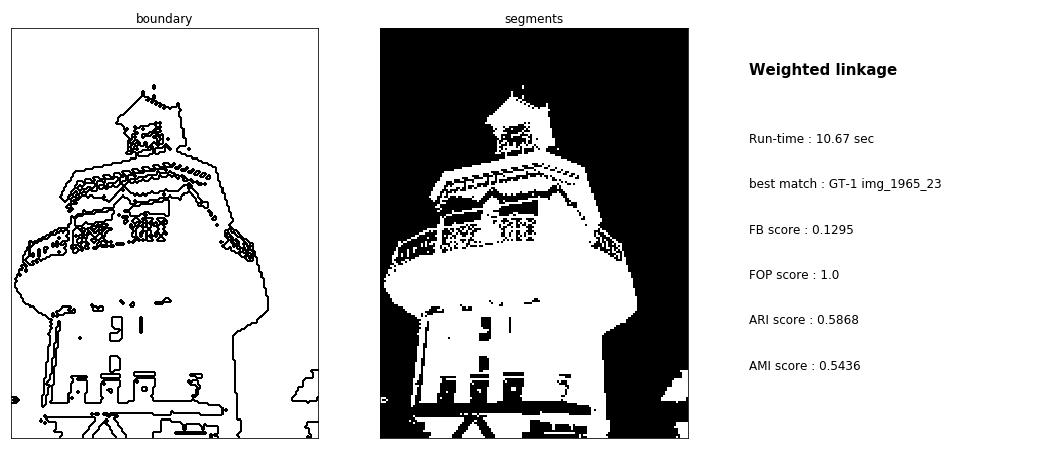

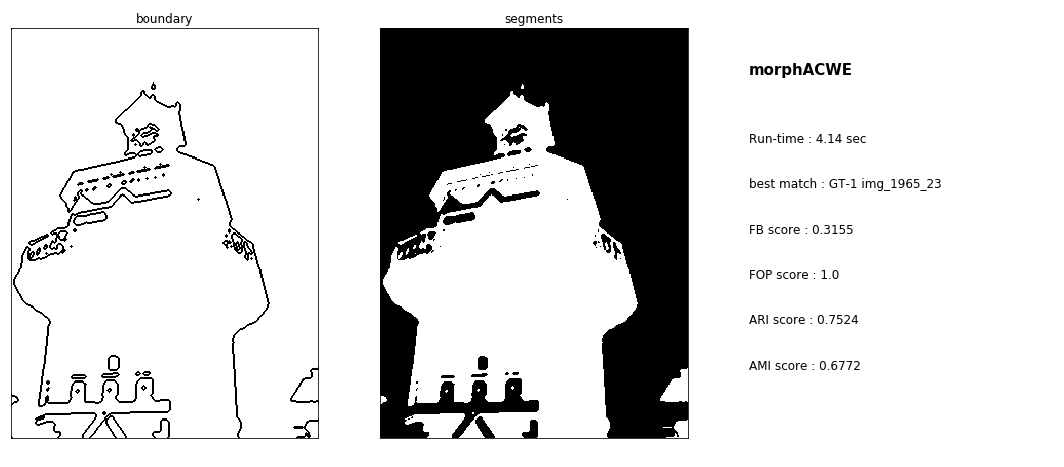

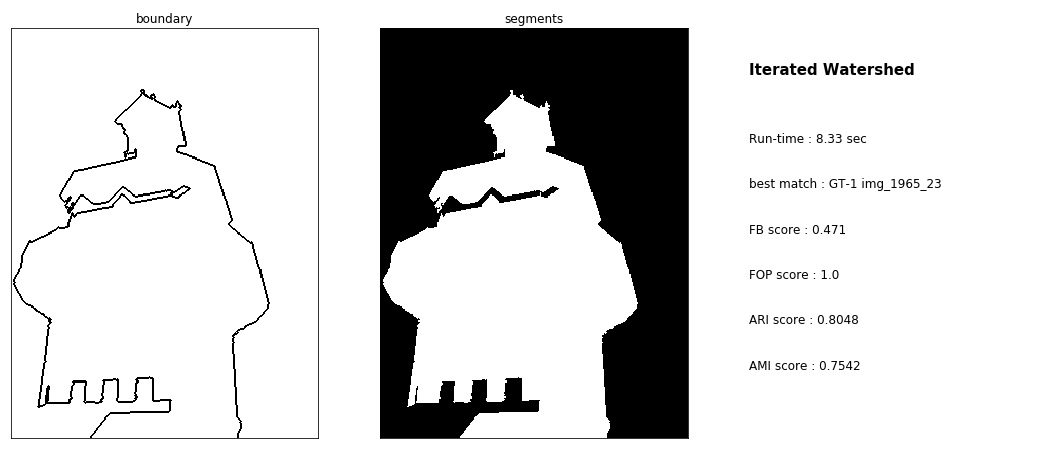

In [27]:
noOfObj=1
for imageName in ['crw_0384','100_0109','img_1965']:
    generateEvaluationPlot(imageName,noOfObj)

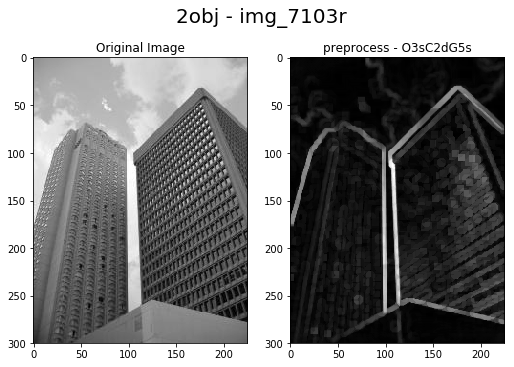

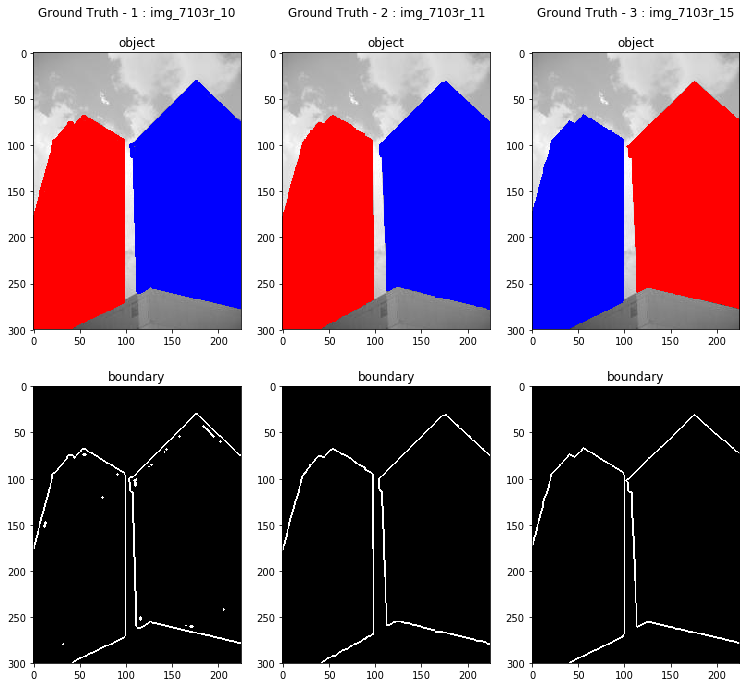

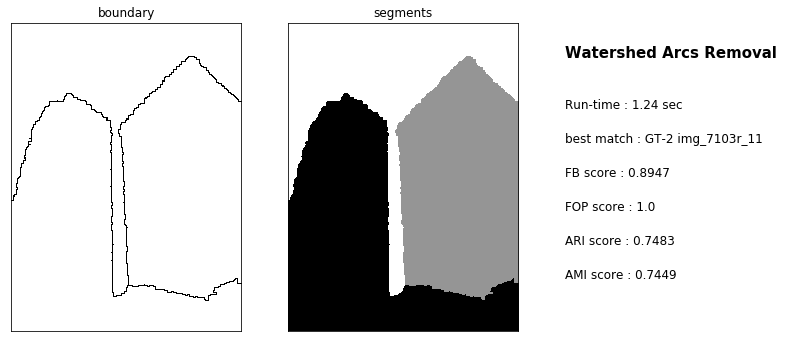

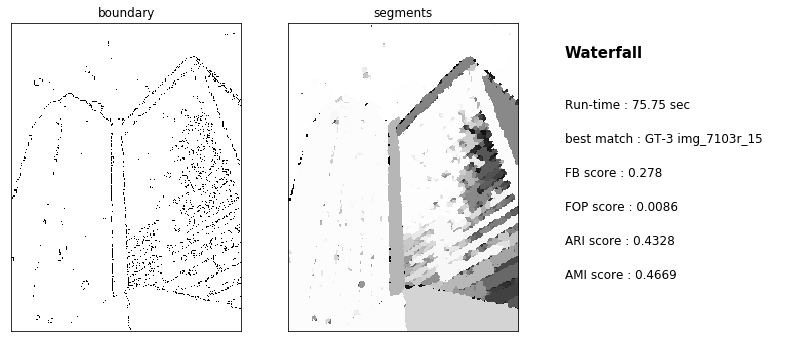

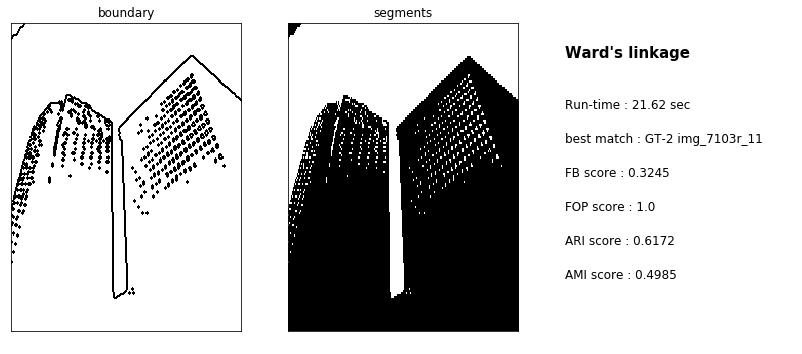

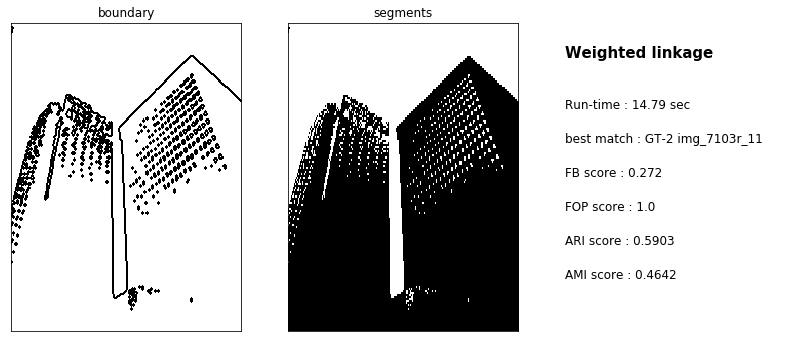

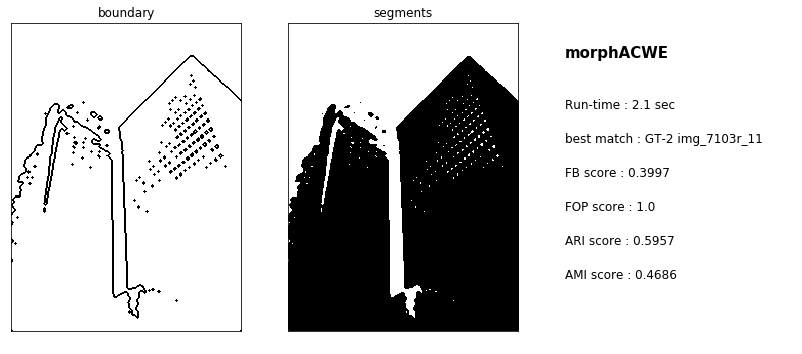

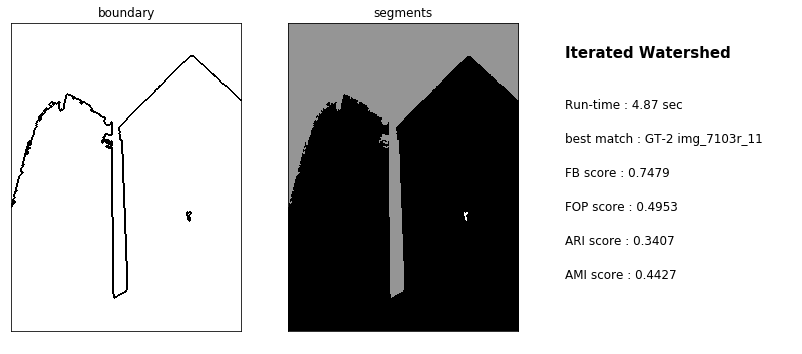

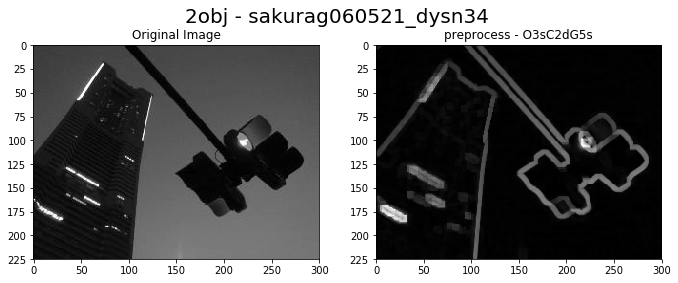

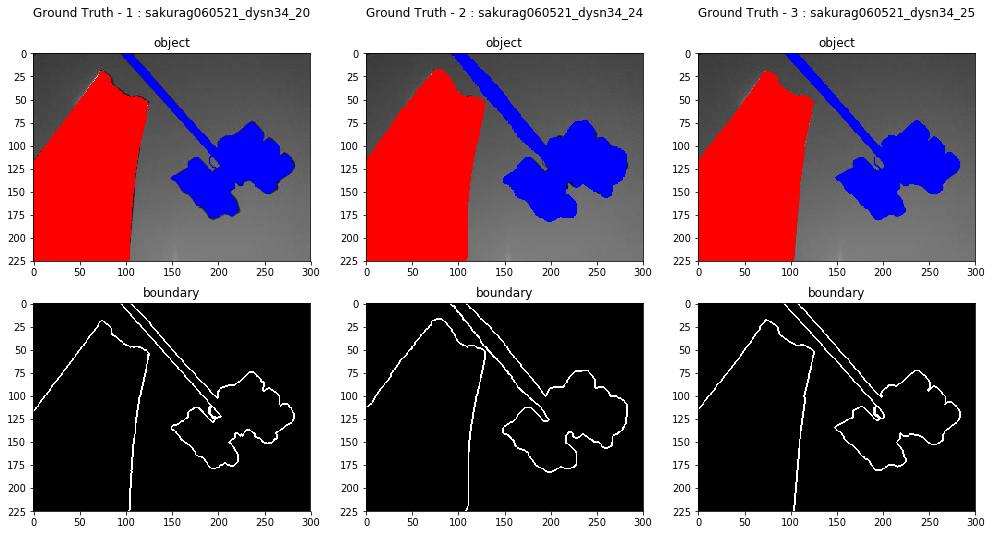

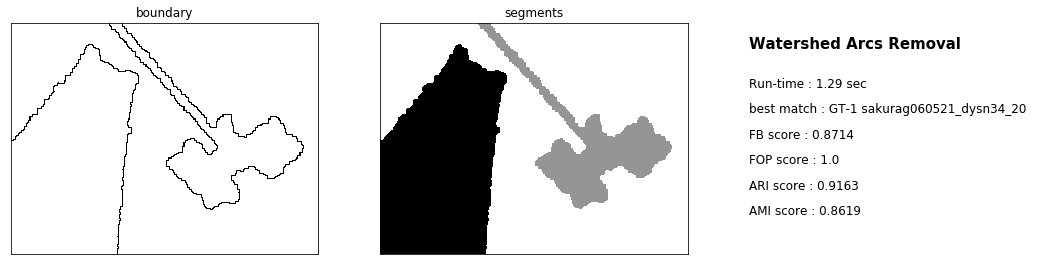

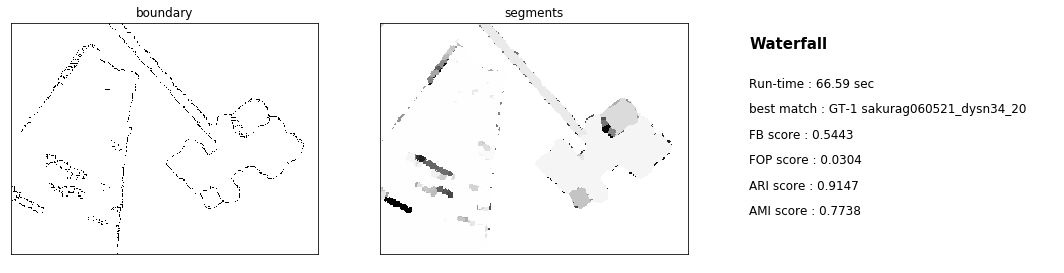

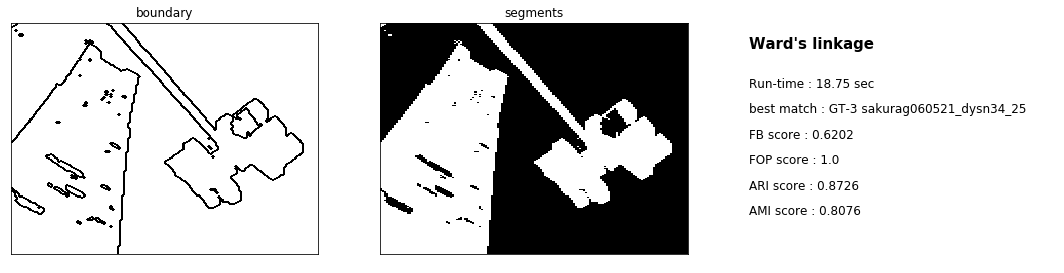

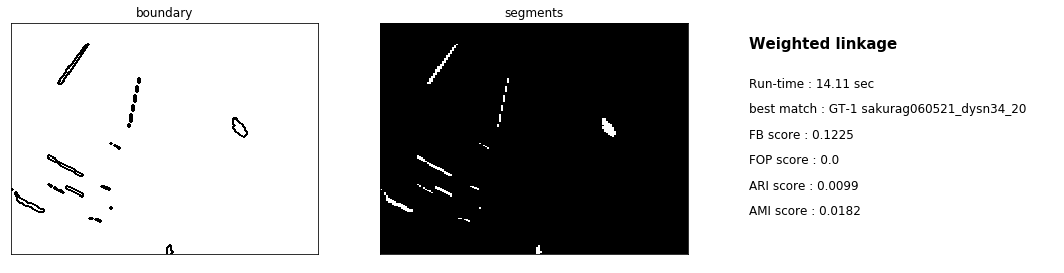

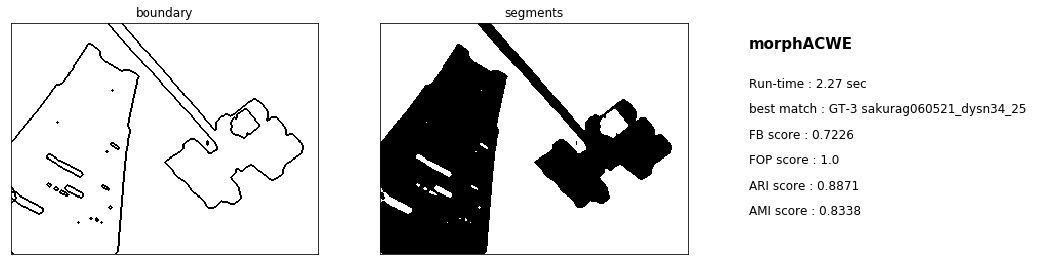

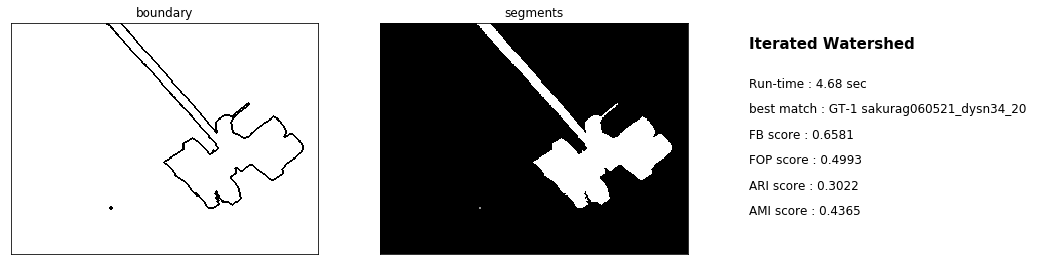

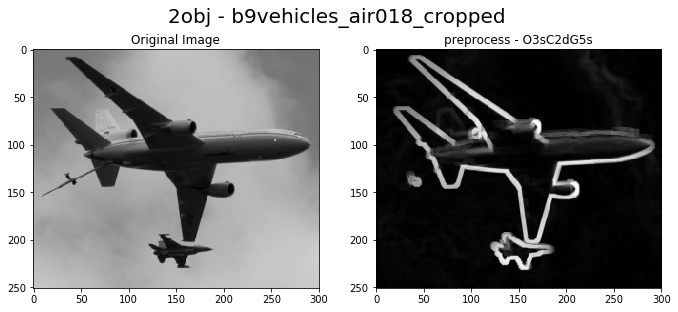

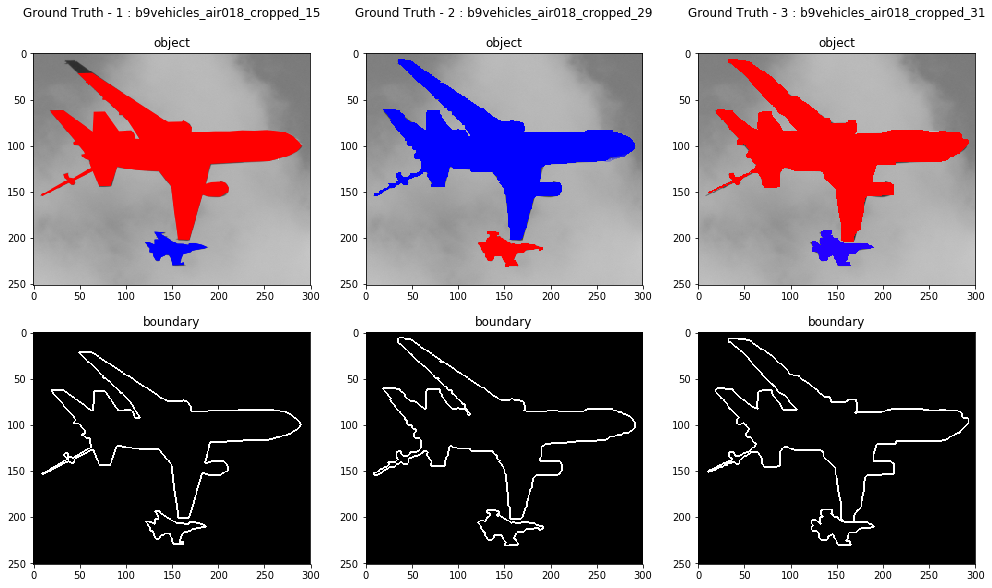

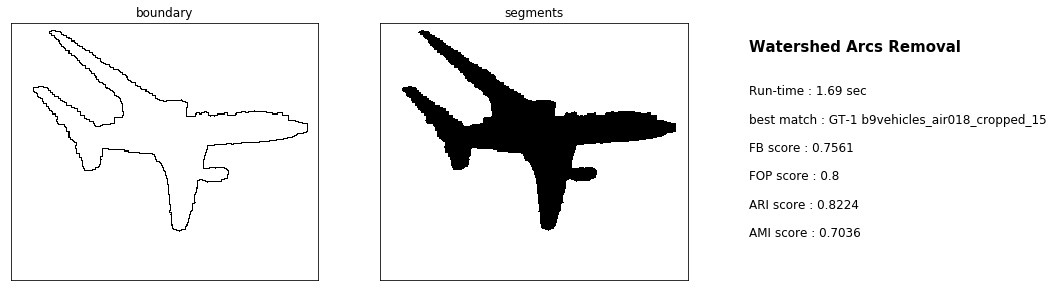

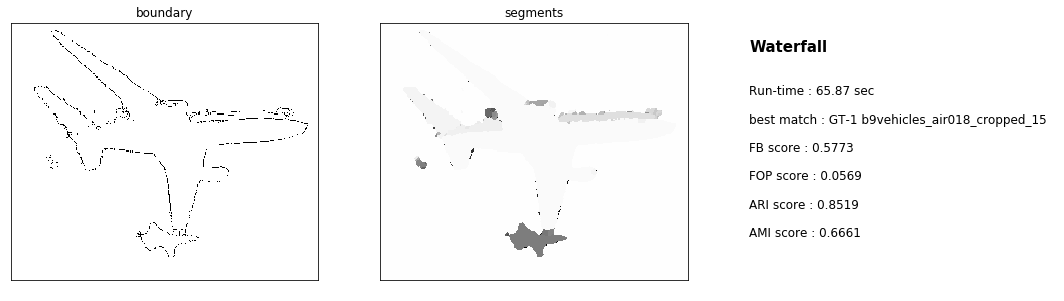

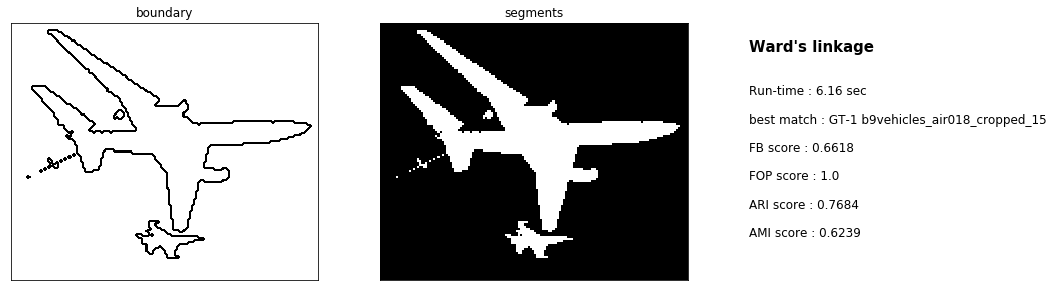

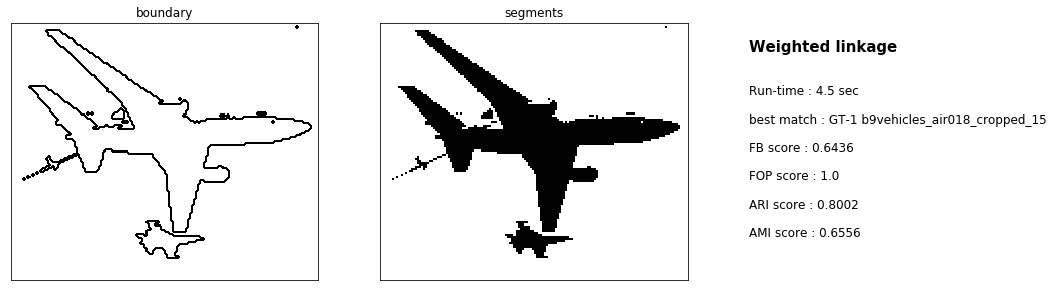

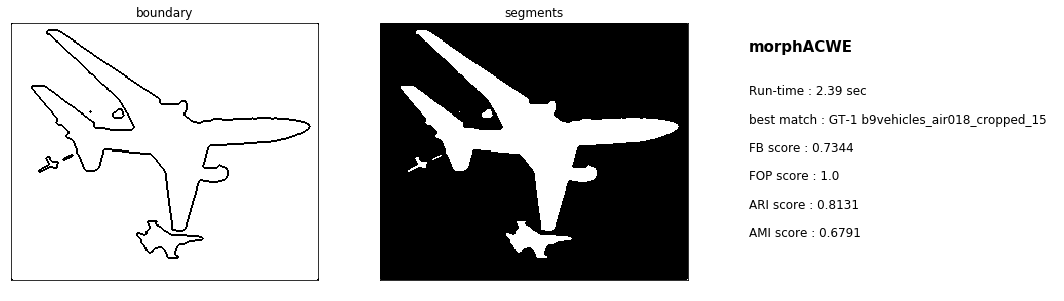

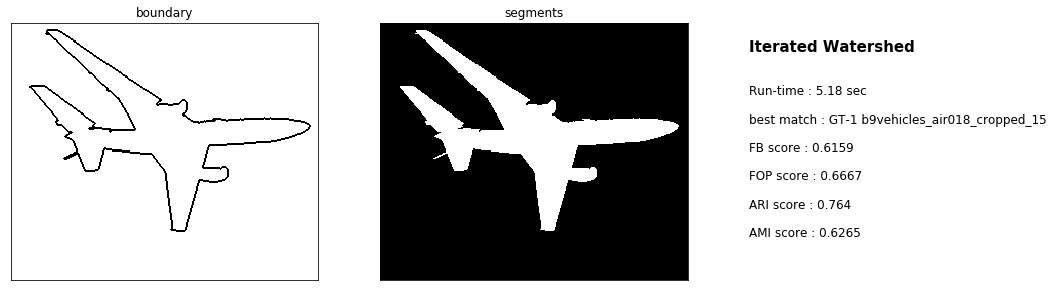

In [23]:
noOfObj=2
for imageName in ['img_7103r','sakurag060521_dysn34','b9vehicles_air018_cropped']:
    generateEvaluationPlot(imageName,noOfObj)

In [29]:
imgName="img_1965Weighted linkage.png"
I=cv2.imread(imgName,0)
I2=I[4:-4,5:-3]
I2=255-I2
I[4:-4,5:-3]=I2
cv2.imwrite(imgName,I)

True

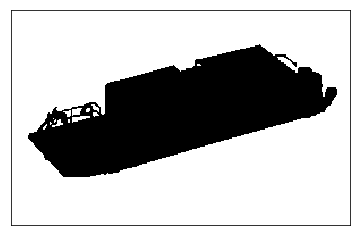

In [43]:
imgName="WD_1bj_gt_2.png"
thisObjImg=cv2.imread(imgName)

gtSeg=np.ones((thisObjImg.shape[0],thisObjImg.shape[1]),dtype=np.int)
for i in range(thisObjImg.shape[0]):
    for j in range(thisObjImg.shape[1]):
        if thisObjImg[i,j,0]==thisObjImg[i,j,1]==thisObjImg[i,j,2]: continue
        if thisObjImg[i,j,2]==255: gtSeg[i,j]=2
        elif thisObjImg[i,j,0]==255: gtSeg[i,j]=3

dispSize = 1.5*thisObjImg.shape[1] / float(dpi), 1.5*thisObjImg.shape[0] / float(dpi)
fig, ax = plt.subplots(1,1,figsize=(dispSize[0],dispSize[1]))
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(gtSeg, cmap='Greys',  interpolation='nearest')
plt.show()
bbox = ax.get_tightbbox(fig.canvas.get_renderer())
fig.savefig(imgName,
          bbox_inches=bbox.transformed(fig.dpi_scale_trans.inverted()))